# Darlin Joel Anacicha Sanchez GR1CC
# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [102]:
from sklearn.datasets import load_files
import pandas as pd

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

train_data = load_files('/kaggle/input/dataaset/20news-bydate-train', encoding='latin1')
test_data  = load_files('/kaggle/input/dataaset/20news-bydate-test', encoding='latin1')

def limpiar_texto(t):
    t = t.lower()
    t = re.sub(r'(from|subject|re|writes|email|organization):.*\n?', ' ', t)
    t = re.sub(r'\S+@\S+', ' ', t)
    t = re.sub(r'http\S+|www\.\S+', ' ', t)
    t = re.sub(r'[-_=*#<>/\\|~`]+', ' ', t)
    t = re.sub(r'\.+', ' ', t)
    t = re.sub(r'\d+', ' ', t)
    t = re.sub(r'[^a-z ]+', ' ', t)
    t = re.sub(r'\b[a-z]{1,2}\b', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t
    
docs_raw = train_data.data + test_data.data
targets = train_data.target.tolist() + test_data.target.tolist()
labels = train_data.target_names

docs_limpios = [limpiar_texto(doc) for doc in docs_raw]
docs_demo = docs_limpios[:100]

df = pd.DataFrame({
    'texto': [doc[:200] for doc in docs_limpios], 
    'categoria_id': targets,
    'categoria_nombre': [labels[i] for i in targets]
})

df.head(100)

,texto,categoria_id,categoria_nombre
0,article agate lines nntp posting host garnet b...,9,rec.sport.baseball
1,article pion apr lines well just got centris y...,4,comp.sys.mac.hardware
2,lines expires may gmt reply nntp posting host ...,11,sci.crypt
3,lines attention mac quadra owners many storage...,4,comp.sys.mac.hardware
4,lines nntp posting host lloyd caltech edu robe...,0,alt.atheism
...,...,...,...
95,lines michael smith similarly have trained mys...,4,comp.sys.mac.hardware
96,lines nntp posting host psycho ecst csuchico e...,2,comp.os.ms-windows.misc
97,article shelley qngqlinnnp lines nntp posting ...,12,sci.electronics
98,distribution usa lines les bartel comments sor...,7,rec.autos


## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [103]:
vectorizador_tf = CountVectorizer()
vectorizador_tfidf = TfidfVectorizer()

matriz_tf = vectorizador_tf.fit_transform(docs_demo)
matriz_tfidf = vectorizador_tfidf.fit_transform(docs_demo)

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [104]:
consulta = input("Ingresa tu consulta: ").lower()

vec_consulta = vectorizador_tfidf.transform([consulta])
sim = cosine_similarity(vec_consulta, matriz_tfidf).flatten()
ranking = sim.argsort()[::-1][:10]

resultado = pd.DataFrame({
    "Documento": ranking,
    "Puntaje": sim[ranking],
    "Categoria": [labels[targets[i]] for i in ranking],
    "Texto": [docs_demo[i][:200] + "..." for i in ranking]
})

print("\n=== RANKING TF-IDF ===")
display(resultado)

Ingresa tu consulta:  computer



=== RANKING TF-IDF ===


,Documento,Puntaje,Categoria,Texto
0,2,0.123982,sci.crypt,lines expires may gmt reply nntp posting host ...
1,34,0.095873,comp.sys.ibm.pc.hardware,summary gamecards keywords gamecards nntp post...
2,40,0.078461,rec.autos,lines nntp posting host tamuts tamu edu articl...
3,1,0.063898,comp.sys.mac.hardware,article pion apr lines well just got centris y...
4,69,0.062964,sci.space,summary space digest address nntp posting host...
5,59,0.056556,sci.electronics,lines missed the first article this line due n...
6,3,0.043251,comp.sys.mac.hardware,lines attention mac quadra owners many storage...
7,25,0.025929,sci.med,article gary merrill article mark fulk what wr...
8,36,0.000000,sci.med,lines article gong tong article opirg for cite...
9,28,0.000000,comp.os.ms-windows.misc,reply david clarke lines has anyone else exper...


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [105]:
corpus = [doc.split() for doc in docs_demo]

k1, b = 1.5, 0.75
N = len(corpus)
lens = np.array([len(doc) for doc in corpus])
avgdl = np.mean(lens)

df = {}
for doc in corpus:
    for w in set(doc):
        df[w] = df.get(w, 0) + 1

idf = {w: np.log((N - df[w] + 0.5)/(df[w] + 0.5) + 1) for w in df}

q = consulta.split()

scores = []
for doc in corpus:
    score = 0
    for w in q:
        if w in doc:
            tf = doc.count(w)
            denom = tf + k1*(1 - b + b*len(doc)/avgdl)
            score += idf[w] * (tf * (k1 + 1)) / denom
    scores.append(score)

top = np.argsort(scores)[::-1][:10]

resultado_bm25 = pd.DataFrame({
    "Documento": top,
    "Score_BM25": [scores[i] for i in top],
    "Categoria": [labels[targets[i]] for i in top],
    "Texto": [docs_demo[i][:200] + "..." for i in top]
})

print("\n=== RANKING BM25 ===")
display(resultado_bm25)


=== RANKING BM25 ===


,Documento,Score_BM25,Categoria,Texto
0,2,3.960218,sci.crypt,lines expires may gmt reply nntp posting host ...
1,34,3.562176,comp.sys.ibm.pc.hardware,summary gamecards keywords gamecards nntp post...
2,40,3.412886,rec.autos,lines nntp posting host tamuts tamu edu articl...
3,69,3.214754,sci.space,summary space digest address nntp posting host...
4,1,2.868390,comp.sys.mac.hardware,article pion apr lines well just got centris y...
5,59,2.776349,sci.electronics,lines missed the first article this line due n...
6,3,2.551226,comp.sys.mac.hardware,lines attention mac quadra owners many storage...
7,25,1.511938,sci.med,article gary merrill article mark fulk what wr...
8,36,0.000000,sci.med,lines article gong tong article opirg for cite...
9,28,0.000000,comp.os.ms-windows.misc,reply david clarke lines has anyone else exper...


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

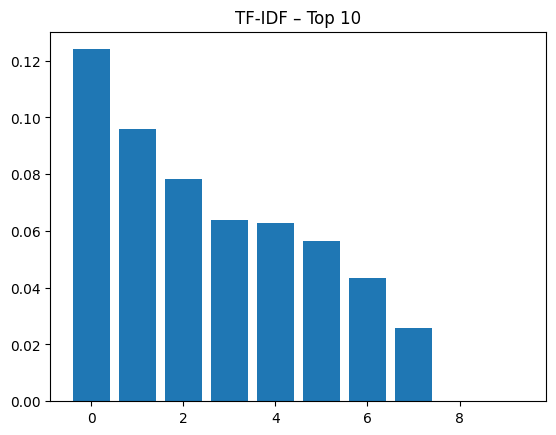

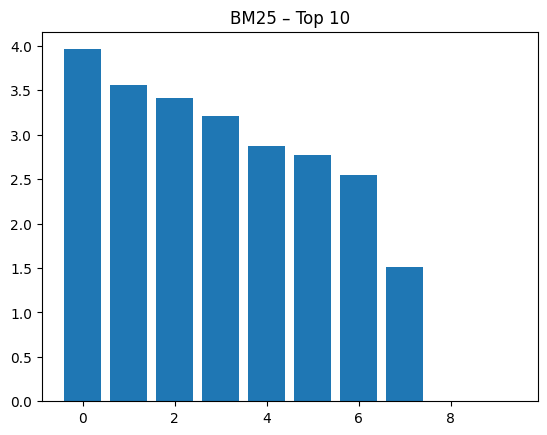

In [106]:
plt.bar(range(10), resultado["Puntaje"].tolist())
plt.title("TF-IDF – Top 10")
plt.show()

scores_np = np.array(scores)
plt.bar(range(10), scores_np[top].tolist())
plt.title("BM25 – Top 10")
plt.show()

## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [107]:
relev = ['comp.graphics','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
def is_rel(i): return labels[targets[i]] in relev

docs_tfidf = resultado["Documento"].tolist()
docs_bm25 = top.tolist()

p3_tfidf = sum(is_rel(i) for i in docs_tfidf[:3]) / 3
p3_bm25  = sum(is_rel(i) for i in docs_bm25[:3]) / 3

print("\nPrecision@3 TF-IDF:", p3_tfidf)
print("Precision@3 BM25 :", p3_bm25)

def MAP(r):
    c = s = 0
    for i,d in enumerate(r,1):
        if is_rel(d):
            c += 1; s += c/i
    return s / (c if c > 0 else 1)

print("MAP TF-IDF:", MAP(docs_tfidf))
print("MAP BM25 :", MAP(docs_bm25))


Precision@3 TF-IDF: 0.3333333333333333
Precision@3 BM25 : 0.3333333333333333
MAP TF-IDF: 0.4761904761904762
MAP BM25 : 0.44285714285714284
